# ECON 323 Final Project

###### Factors affecting bike share in San Francisco

## Background 
Bike sharing is an increasingly popular service, especially as cities are moving to be more sustainable. [Eren and Uz (2020)](https://www.sciencedirect.com/science/article/abs/pii/S2210670719312387) identified several factors affecting bike sharing, including weather (e.g. seasons, precipitation, and temperature), public transportation, safety, and other temporal factors. Bay Wheels is a bike sharing service in San Francisco provided by Lyft (similar to the Shaw Mobi bikes in Vancouver). Some differences are that Bay Wheels provides both electric bikes and regular bikes, and that the service is accessible through the Lyft application and Clipper cards (similar to Vancouver’s Compass card).  Bay Wheels’ dataset is publicly available on Lyft’s website at https://www.lyft.com/bikes/bay-wheels/system-data. This project aims to look at factors that influence bike sharing in San Francisco.

## Literature Review
Based on Eren and Uz (2020)’s findings, the optimal temperature for bike sharing hovers around 20 – 30 °C with no precipitation, while the 10-20 °C range also has a positive correlation in bike sharing. Eren and Uz also found that bike sharing can be used as a substitute for public transportation in areas with poor public transport options or at times where services are reduced (e.g. late night/early morning). However, bike sharing services are also used as complements to public transportation to reduce travel time. Eren and Uz found that the correlation between income level and usage of bike share services tend to be strongly correlated as income goes up. However, Guo et al (2017) found that in Ningbo, China found that the use of bike sharing services are highest among lower income residents, followed by middle-income and high-income respectively. 

## Hypothesis/Research

Using Eren and Uz (2020)’s findings as a starting point, I will look at how the following factors affect bike sharing in San Francisco. 

* **Weather** – San Francisco’s mild coastal weather ranges around 8 – 21 °C all year round, with an average of 8 days of precipitation in the winter months and 0 days in the summer months. These numbers make San Francisco’s weather the ideal conditions for bike sharing. I will examine whether seasonality still influences bike sharing in San Francisco by cross-examining weather data with start/end times for bike share sessions.

* **Public transportation** – I will look bike share usage along BART (rail/subway), Caltrain, and MUNI (light rail and cable car) stops and the time of day. Since many working in the city are commuters, I would expect higher usages along major transit stops before/after work hours. 

* **Safety** – I will see whether crime rate (from San Francisco Police Department) affects bike share usage. Safety is often cited as a concern for bike share users, and I expect there to be a negative correlation between bike share usage and crime rate. 

* **Temporal factors** - I will break down bike share usage by weekdays/weekends, and also the time of day. 

## Dataset
The main dataset used in this analysis comes from Lyft's Bay Wheels bike share system data from June 2019 to March 2021 (the most recently available). It is available at https://www.lyft.com/bikes/bay-wheels/system-data. I have chosen to exclude data prior to Lyft's acquisitation of Bay Wheels in June 2019 (previously Ford GoBike), as the rebrand led to slight changes to the bike share model (e.g. docked and dockless bikes, increased electrical bikes, etc...) and the rental access methods (i.e. the bikes can now be rented through the Lyft app). Bay Wheels operates in San Francisco, Oakland, Berkeley, Emeryville, and San Jose. I will focus this study on bike sharing in San Francisco only. 

Other datasets used:
* [San Francisco GeoPolygon](http://www2.census.gov/geo/tiger/PREVGENZ/ma/ma99/ce00shp/ce99_d00_shp.zip) for filtering for San Francisco data only
* [Historical weather records from San Francisco Bay Area Weather Forecast Office](https://w2.weather.gov/climate/xmacis.php?wfo=mtr)
* [Passenger rail stations data from California's Metropolitan Transportation Commission (MTC)](https://opendata.mtc.ca.gov/datasets/efd75b7bb3c04dbda06c6e7cd73e9336_0?geometry=-122.954%2C37.659%2C-121.976%2C37.849), which includes Bay Area Rapid Transit (BART), Caltrain, and San Francisco Municipal Railway (MUNI - light rail and cable car) data
* [Incidents report from San Francisco Police Department (2018 to Present)](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783)
* [San Francisco Neighborhoods from San Francisco Open Data (DataSF)](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h)

## Outline
1. **Examining temporal factors:** visualizations of time of day and weekday/weekend usage of bike shares, as well as user types over weekday/weekends (casual versus subscribed member)

2. **Examining the role of weather:** visualization of daily temperature, precipitation, and rate of bike shares

3. **Examining safety and public transportation as factors affeting bike sharing:** map visualization of pubic transportation (BART, MUNI, Caltrain) stations, crime rate for each neighborhood, and bike share usage based on start location 

4. **Training a linear regression model to predict bike share usage** comparing linear regression and one with polynomial transformations applied

5. **Conclusion:** discussion of limitations, areas for further research

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd

all_files_to_format = ['201906-baywheels-tripdata.csv', '201907-baywheels-tripdata.csv',
                       '201908-baywheels-tripdata.csv', '201909-baywheels-tripdata.csv', 
                       '201910-baywheels-tripdata.csv','201911-baywheels-tripdata.csv',
                       '201912-baywheels-tripdata.csv', '202001-baywheels-tripdata.csv',
                       '202002-baywheels-tripdata.csv', '202003-baywheels-tripdata.csv']

all_files = ['202004-baywheels-tripdata.csv', '202005-baywheels-tripdata.csv', '202006-baywheels-tripdata.csv', 
             '202007-baywheels-tripdata.csv', '202008-baywheels-tripdata.csv', '202009-baywheels-tripdata.csv', 
             '202010-baywheels-tripdata.csv', '202011-baywheels-tripdata.csv', '202012-baywheels-tripdata.csv',
             '202101-baywheels-tripdata.csv', '202102-baywheels-tripdata.csv', '202103-baywheels-tripdata.csv']

# read each month's data and append them to the df
li = []
for filename in all_files_to_format:
    df = pd.read_csv(filename, index_col=None, header=0, dtype={'bike_share_for_all_trip': 'string', 'rental_access_method': 'string'})
    # pre-2020 data has some discrepancies in column names and values, rename them to match 2020 data
    df = df.rename(columns={'start_station_latitude': 'start_lat', 'start_station_longitude': 'start_lng',
                           'end_station_latitude': 'end_lat', 'end_station_longitude': 'end_lng',
                           'user_type': 'member_casual', 'start_time': 'started_at', 'end_time': 'ended_at'
                          })
    df = df.replace({'member_casual': r'Customer$'}, {'member_casual': 'casual'}, regex=True)
    df = df.replace({'member_casual': r'Subscriber$'}, {'member_casual': 'member'}, regex=True)
    li.append(df)
    
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, dtype={'bike_share_for_all_trip': 'string', 'rental_access_method': 'string'})
    li.append(df)

lyft_data = pd.concat(li, axis=0, ignore_index=True)


# add new column to df to filter for sf data only
lyft_data['withinSF'] = 1
withinSFlist = []

# get sf polygon
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/PREVGENZ/ma/ma99/ce00shp/ce99_d00_shp.zip")
SF_polygon = state_df.loc[state_df['NAME'] == 'San Francisco'].iloc[1].geometry

for lon,lat in zip(lyft_data.start_lng, lyft_data.start_lat):
    pt = Point(lon, lat)
    withinSF = SF_polygon.contains(pt)
    withinSFlist.append(withinSF)
    
lyft_data['withinSF'] = withinSFlist
lyft_data = lyft_data[lyft_data.withinSF == 1]

# drop unused/renamed cols
lyft_data = lyft_data.drop(columns=['withinSF', 'duration_sec', 'ride_id'])

lyft_data

,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bike_id,member_casual,bike_share_for_all_trip,rental_access_method,rideable_type
0,2019-06-30 18:16:09.7730,2019-07-01 16:57:45.5920,109,17th St at Valencia St,37.763316,-122.421904,56,Koshland Park,37.773414,-122.427317,1502.0,member,No,<NA>,NaN
1,2019-06-30 18:09:55.8300,2019-07-01 14:47:36.6810,50,2nd St at Townsend St,37.780526,-122.390288,101,15th St at Potrero Ave,37.767079,-122.407359,2526.0,casual,No,<NA>,NaN
2,2019-06-30 15:40:31.0380,2019-07-01 08:13:54.3490,23,The Embarcadero at Steuart St,37.791464,-122.391034,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,2427.0,member,No,<NA>,NaN
4,2019-06-30 17:21:00.0550,2019-07-01 06:55:54.9960,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,1070.0,casual,No,<NA>,NaN
6,2019-06-30 14:31:39.5730,2019-07-01 00:53:02.2520,6,The Embarcadero at Sansome St,37.804770,-122.403234,400,Buchanan St at North Point St,37.804272,-122.433537,1980.0,casual,No,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944933,2021-03-17 15:28:27,2021-03-17 15:29:10,SF-C28-2,Broadway at Battery St,37.798572,-122.400869,SF-C28-2,Broadway at Battery St,37.798572,-122.400869,NaN,casual,NaN,NaN,classic_bike
3944935,2021-03-26 11:27:13,2021-03-26 11:38:59,SF-C28-2,Broadway at Battery St,37.798509,-122.400834,SF-C28-2,Broadway at Battery St,37.798637,-122.400695,NaN,casual,NaN,NaN,electric_bike
3944936,2021-03-21 11:24:06,2021-03-21 11:25:33,SF-E18,Divisadero St at Clay St,37.789588,-122.440683,SF-E18,Divisadero St at Clay St,37.789588,-122.440683,NaN,casual,NaN,NaN,classic_bike
3944937,2021-03-29 20:34:27,2021-03-29 20:47:19,SF-BB17,London St at Geneva Ave,37.716183,-122.440112,SF-BB17,London St at Geneva Ave,37.716209,-122.440078,NaN,casual,NaN,NaN,electric_bike


In [8]:
import datetime
import seaborn as sns

# convert timestamp into useful date/hour/day of week columns we can use

def getDate(timestamp):
    date_only = timestamp.split()[0]
    return date_only

def getYear(timestamp):
    date_only = timestamp.split()[0]
    date_arr = date_only.split('-')
    year = int(date_arr[0])
    return year

def getMonth(timestamp):
    date_only = timestamp.split()[0]
    date_arr = date_only.split('-')
    month = int(date_arr[1])
    return month

def getDayOfWeek(timestamp):
    date_only = timestamp.split()[0]
    date_arr = date_only.split('-')
    year = int(date_arr[0])
    month = int(date_arr[1])
    day = int(date_arr[2])
    return datetime.datetime(year, month, day).weekday()

def getHourOfDay(timestamp):
    time_only = timestamp.split()[1]
    time_arr = time_only.split(':')
    return time_arr[0]

def isWeekend(day_of_week):
    return day_of_week > 4

lyft_data['date'] = lyft_data.apply(lambda row: getDate(row.started_at), axis=1)
lyft_data['year']= lyft_data.apply(lambda row: getYear(row.started_at), axis=1)
lyft_data['month'] = lyft_data.apply(lambda row: getMonth(row.started_at), axis=1)
lyft_data['day_of_week'] = lyft_data.apply(lambda row: getDayOfWeek(row.started_at), axis=1)
lyft_data['is_weekend'] = lyft_data.apply(lambda row: isWeekend(row.day_of_week), axis=1)
lyft_data['hour_of_day'] = lyft_data.apply(lambda row: getHourOfDay(row.started_at), axis=1)

lyft_data.head()

,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,...,member_casual,bike_share_for_all_trip,rental_access_method,rideable_type,date,year,month,day_of_week,is_weekend,hour_of_day
0,2019-06-30 18:16:09.7730,2019-07-01 16:57:45.5920,109,17th St at Valencia St,37.763316,-122.421904,56,Koshland Park,37.773414,-122.427317,...,member,No,<NA>,NaN,2019-06-30,2019,6,6,True,18
1,2019-06-30 18:09:55.8300,2019-07-01 14:47:36.6810,50,2nd St at Townsend St,37.780526,-122.390288,101,15th St at Potrero Ave,37.767079,-122.407359,...,casual,No,<NA>,NaN,2019-06-30,2019,6,6,True,18
2,2019-06-30 15:40:31.0380,2019-07-01 08:13:54.3490,23,The Embarcadero at Steuart St,37.791464,-122.391034,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,...,member,No,<NA>,NaN,2019-06-30,2019,6,6,True,15
4,2019-06-30 17:21:00.0550,2019-07-01 06:55:54.9960,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,...,casual,No,<NA>,NaN,2019-06-30,2019,6,6,True,17
6,2019-06-30 14:31:39.5730,2019-07-01 00:53:02.2520,6,The Embarcadero at Sansome St,37.804770,-122.403234,400,Buchanan St at North Point St,37.804272,-122.433537,...,casual,No,<NA>,NaN,2019-06-30,2019,6,6,True,14


## 1) Examining Temporal Factors

Looking at usage over weekdays/weekends and over different times of day.

[Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Figure 2: Distribution of Usage by Day of Week')]

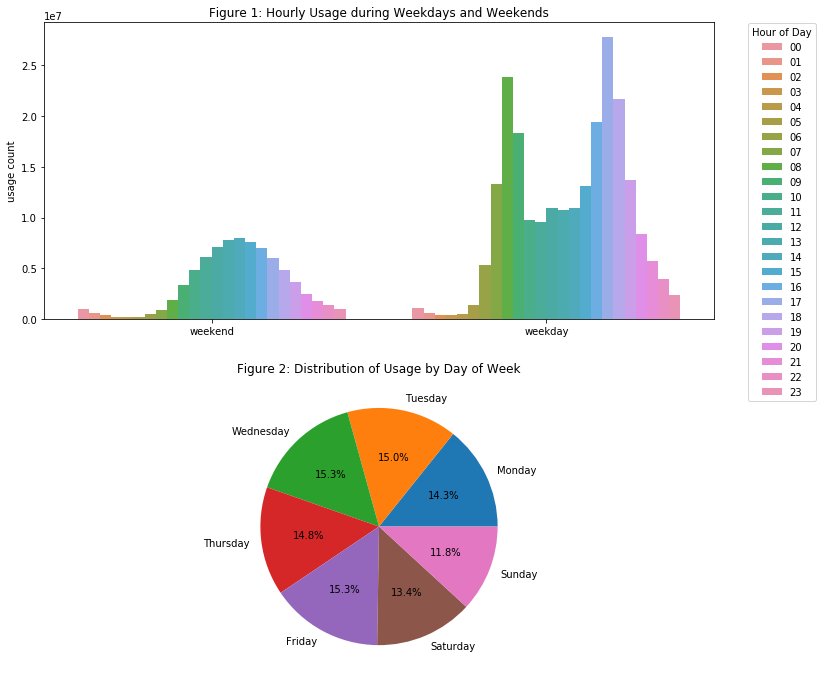

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# group data based on weekday/weekend and hour of day
hourly_usage = (lyft_data.groupby(['is_weekend'])['hour_of_day'].value_counts()
                   .rename('usage count')
                   .mul(100)
                   .reset_index()
                   .sort_values('hour_of_day'))

hourly_usage = hourly_usage.replace({'is_weekend': True}, {'is_weekend': 'weekend'}, regex=True)
hourly_usage = hourly_usage.replace({'is_weekend': False}, {'is_weekend': 'weekday'}, regex=True)


hourly_usage_plot = sns.barplot(ax=axes[0], x="is_weekend", y="usage count", hue="hour_of_day", data=hourly_usage)
hourly_usage_plot.set(xlabel=None, title='Figure 1: Hourly Usage during Weekdays and Weekends')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1, title='Hour of Day')

# Plot usage data for each day of the week
weekday_data = lyft_data.groupby(['day_of_week']).count()

labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_plot = weekday_data.plot.pie(ax=axes[1], y='started_at', labels=labels, autopct='%1.1f%%')
axes[1].get_legend().remove()
weekday_plot.set(ylabel=None, title='Figure 2: Distribution of Usage by Day of Week')

The distribution of usage by day of week (*Figure 2*) shows that usage is slightly higher towards the weekend, but it's mostly equally distributed. However, the hourly usages vary quite a bit over the weekend versus weekday. 

According to *Figure 1*, weekday usage seems to peak when people get to work and when they get off work. Usage is also higher in the evenings, suggesting that people might use bike sharing as a more leisurely means of getting home, when they do not face the pressure of having to get to work on time (like in the mornings). On weekends, usage seems mirror people's leisure activities and peaks during the middle of the day. 

Next, let's compare the type of users over the weekend/weekday. 

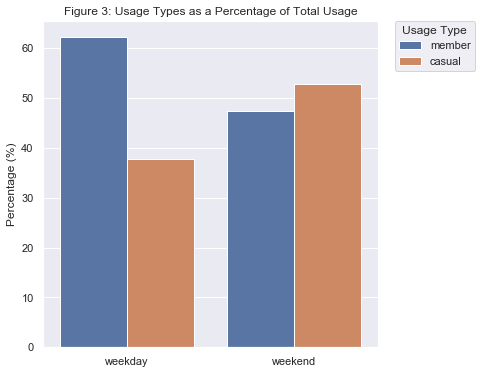

In [11]:
weekday_usage_types = (lyft_data.groupby(['is_weekend'])['member_casual'].value_counts(normalize=True)
                   .rename('percentage')
                   .mul(100)
                   .reset_index())

weekday_usage_types = weekday_usage_types.replace({'is_weekend': True}, {'is_weekend': 'weekend'}, regex=True)
weekday_usage_types = weekday_usage_types.replace({'is_weekend': False}, {'is_weekend': 'weekday'}, regex=True)

sns.set(rc={'figure.figsize':(6, 6)})
weekday_usage_types_plot = sns.barplot(x="is_weekend", y="percentage", hue="member_casual", data=weekday_usage_types)
weekday_usage_types_plot.set(xlabel=None, ylabel='Percentage (%)', title='Figure 3: Usage Types as a Percentage of Total Usage')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Usage Type')

On weekdays, the share of casual versus subscribed (member) users are quite equally distributed. However, during weekends, casual users take up a much higher proportion of bike share usage. Based on the graphed usage by hour in *Figure 1*, usage seems to peak around evening commute hours, which suggests a siginificant amount of subscribed weekly commutters using bikes as a means to get home on a regular basis.

## 2) Examining the role of weather

Looking at each day's bike share usage, plotted against temperature and precipitation. I will look at monthly usage counts and monthly averages of temperature and precipitation. To examine this relationship further, I will plot average daily temperatures and precipitation against bike share usage counts. 

An outline of the steps below
1. Get daily weather data (temperature and precipitation), convert to metric units
2. Calculate the average monthly weather data, total up monthly bike share usage counts, and plot them by month.
3. Group the Lyft bike share data into daily counts, plot these counts against daily temperature and precipitation

In [13]:
import calendar

# read daily weather data files
weather_files_by_year = ['sf_weather_data_2020.csv', 'sf_weather_data_2019.csv', 'sf_weather_data_2021.csv']
li = []
for filename in weather_files_by_year:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
sf_weather = pd.concat(li, axis=0, ignore_index=True)
sf_weather = sf_weather.drop(columns=['Maximum', 'Minimum', 'Departure', 'HDD', 'CDD'])
sf_weather = sf_weather.rename(columns={'Date': 'date', 'Precipitation': 'precipitation', 'Average': 'temp_average'})

def fahr_to_celsius(temp_fahr):
    temp_celsius = (temp_fahr - 32) * 5 / 9
    return temp_celsius

def in_to_cm(precip_in):
    precip_cm = precip_in * 2.54
    return precip_cm

def formatMonthYear(row):
    m = calendar.month_abbr[row['month']]
    y = str(row['year'])
    y = y[-2:]
    return m + " '" + y

# convert units to metric (brrrr imperial)
sf_weather['temp_average'] = sf_weather['temp_average'].astype(float)
sf_weather['temp_average'] = fahr_to_celsius(sf_weather['temp_average'])
sf_weather['precipitation'] = sf_weather['precipitation'].astype(float)
sf_weather['precipitation'] = in_to_cm(sf_weather['precipitation'])


sf_weather['month'] = pd.DatetimeIndex(sf_weather['date']).month
sf_weather['year'] = pd.DatetimeIndex(sf_weather['date']).year
sf_weather['month_year'] = sf_weather.apply(lambda row: formatMonthYear(row), axis=1)

# get each month's average temperature (sf_weather is our daily average)
sf_weather_monthly_average = (sf_weather.groupby(['month', 'year']).mean()
                             .reset_index())

sf_weather_monthly_average.head()

,month,year,temp_average,precipitation
0,1,2019,12.768817,0.374445
1,1,2020,11.568100,0.200742
2,1,2021,11.818996,0.239252
3,2,2019,9.990079,0.652236
4,2,2020,13.534483,0.000000


[Text(0, 0.5, 'usage count'),
 Text(0.5, 0, 'precipitation (cm) / temp (c)'),
 Text(0.5, 1.0, 'Figure 5: Weather and Daily Usage')]

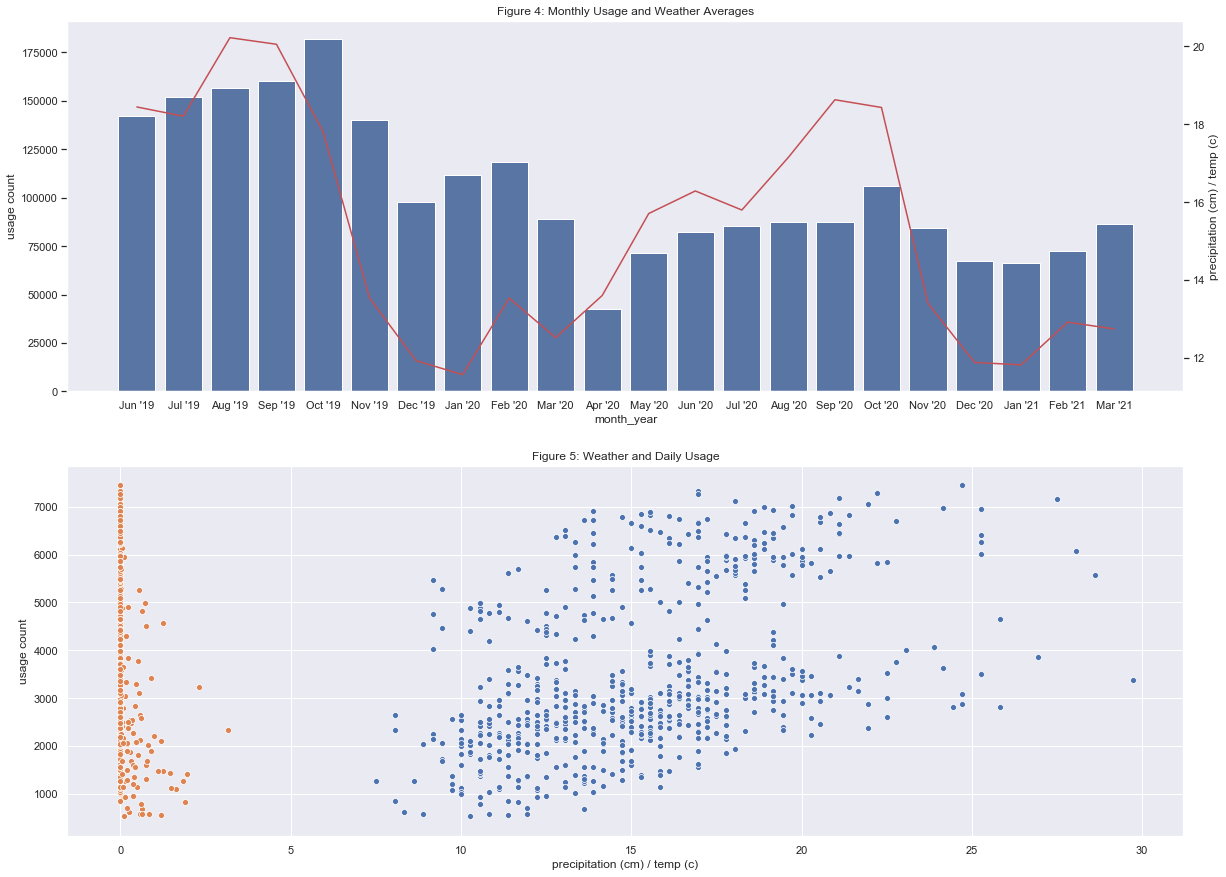

In [242]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))



###################### plot monthly bike share data with weather ###################### 

# get monthly bike share totals
usage_by_month = (lyft_data.groupby(['month', 'year']).size()
                             .rename('usage count')
                             .reset_index())
usage_by_month['month_year'] = usage_by_month.apply(lambda row: formatMonthYear(row), axis=1)

# sort bars by year, then month
usage_by_month = usage_by_month.sort_values(['year', 'month']).reset_index().drop(columns=['index'])
usage_by_month = usage_by_month.reset_index().rename(columns={'index': 'order'})
usage_by_month['month_year'] = pd.Categorical(usage_by_month['month_year'],
                                   categories=usage_by_month['month_year'].tolist(),
                                   ordered=True)
# merge monthly usage data and monthly weather averages
monthly_usage_and_weather = pd.merge(usage_by_month, sf_weather_monthly_average)

# plot monthly usage, temperature, and precipitation data on the same plot
monthly_usage_plot = sns.barplot(ax=axes[0], data=monthly_usage_and_weather, x='month_year', y='usage count', color='b')
ax2 = axes[0].twinx()
monthly_weather_plot = sns.lineplot(data=monthly_usage_and_weather, x='month_year', y='temp_average', color="r", ax=ax2)
axes[0].grid(False)
ax2.grid(False)
monthly_weather_plot.set(xlabel='month', ylabel='precipitation (cm) / temp (c)', title='Figure 4: Monthly Usage and Weather Averages')



###################### showing the relationship between daily bike share counts with weather ###################### 

# get daily bike share totals
lyft_data_daily = (lyft_data.groupby(['date']).size()
                             .rename('count')
                             .reset_index())

# merge daily usage data with daily weather averages
lyft_data_daily = pd.merge(lyft_data_daily, sf_weather)
lyft_data_daily

daily_weather_and_usage_plot = sns.scatterplot(ax=axes[1], data=lyft_data_daily, x="temp_average", y="count")
sns.scatterplot(ax=axes[1], data=lyft_data_daily, x="precipitation", y="count")
daily_weather_and_usage_plot.set(xlabel='precipitation (cm) / temp (c)', ylabel='usage count', title='Figure 5: Weather and Daily Usage')

Based on Figure 4, usage seems to decrease with extremely low temperatures. From October to December of 2020 and 2021, usage and temperatures both fall together. There is a notable spike in usage in January and February of 2020, which can be attributed to the [return of electric bikes](https://www.sfexaminer.com/news/lyft-set-to-return-e-bike-to-sf-streets-after-solving-battery-fire-issue/) after battery issues in July 2019 caused Lyft to pause their electric fleet offerings. From March 19, 2020 to January 25, 2021, California issued a statewide stay-at-home order, which could explain a drop in the usage. Besides the spike from the return of electric bikes at the beginning of 2020, there doesn't seem to be a lot of flucuation in usage in the monthly data. 

Figure 5 is more telling of the relationship between weather and usage. Although San Francisco does not get a lot of rain at all, users are still very sensitive to precipitation levels. At low levels of precipitation, usage is under 10,000 rides per day. At slightly higher levels of precipitation (around 2 – 4cm per day), usage does not go avove 6000 rides per day. Temperatures within the modereate, regular range (of around 10 – 18 °C) does not seem to have much of an effect on bike share usage. However, when temperatures gets warmer (above 20 °C), usage drops to below 8000 rides per day.

These results confirm Eren and Uz (2020)’s findings to an extent. These results confirm Eren and Uz's findings that trip production is positively correlated with temperature when temperature ranges around 0 – 20 °C with no precipitation. Eren and Uz also found that 20 – 30 °C is the temperature range in which temperature bike sharing demand is at the maximum level. These results show that bike sharing demand fluctuates to higher levels around 10 - 20 °C, but the positive correlation is still observed past 20 °C.

## 3) Examing Safety and Public Transportation as Factors Affeting Bike Sharing

Mapping crime rate, public transportation options, and bike share usage

In [241]:
import shapely
from folium.plugins import BeautifyIcon
import folium

sf_latitude = 37.7749
sf_longitude = -122.4194

# Create map
sf_usage_map = folium.Map(
    location=[sf_latitude,sf_longitude],
    zoom_start=13,
    tiles='cartodb positron')

###################### map out crime rate per neighborhood ###################### 

# read sf neighborhood polygons
neighborhoods = gpd.read_file('SF_Analysis_Neighborhoods.csv')
neighborhoods = neighborhoods.drop(columns=['geometry'])
neighborhoods = neighborhoods.rename(columns={'NHOOD': 'Analysis Neighborhood', 'the_geom': 'geometry'})

# read sf crime data
incidents = pd.read_csv('SF_Police_Incident_Reports_2018_to_Present.csv') 
incidents = incidents.dropna(subset=['Latitude', 'Longitude'])

# get a count of incidents by neighborhood, sorted from lowest to highest
incidents_by_neighborhood = (incidents.groupby(['Analysis Neighborhood']).size()
                             .rename('count')
                             .reset_index()
                             .sort_values('count'))

# add color based on number of incidents (for map) 
incidents_by_neighborhood['fill_color'] = pd.cut(incidents_by_neighborhood['count'], bins=5, 
                                                 labels=['#fcfadc', '#F2E750', '#F2B807', '#F28705', '#C52104'])


# get each neighborhood's polygons from the neighborhood dataset
incidents_by_neighborhood = pd.merge(incidents_by_neighborhood, neighborhoods)

# convert polygon data for mapping
geometry = incidents_by_neighborhood['geometry'].map(shapely.wkt.loads)
incidents_by_neighborhood = incidents_by_neighborhood.drop('geometry', axis=1)
neighborhood_incidents_gdf = gpd.GeoDataFrame(incidents_by_neighborhood, crs="EPSG:4326", geometry=geometry)


folium.GeoJson(neighborhood_incidents_gdf,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_color'],
                   'color' : feature['properties']['fill_color'],
                   'fillOpacity' : 0.3,
               }).add_to(sf_usage_map)


###################### add public transit stations data ###################### 

stations = pd.read_csv('Passenger_Rail_Stations_2019.csv')

# add MUNI stations (light rail)
muni_stations = stations[stations['mode'] == 'Light Rail']
for index, row in muni_stations.iterrows():
    lng = row.X
    lat = row.Y
    folium.CircleMarker(
      [lat,lng],
      radius=1,
      color='#d1feff',
      fill=False,
      fill_opacity=1
    ).add_to(sf_usage_map) 

# add Cal Train stations
cal_train_stations = stations[stations['mode'] == 'Commuter Rail']
for index, row in cal_train_stations.iterrows():
    lng = row.X
    lat = row.Y
    folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='#9768D1',
      fill=True,
      fill_color='#9768D1',
      fill_opacity=1
    ).add_to(sf_usage_map) 

# add BART stations (subway)
bart_stations = stations[stations['mode'] == 'Rapid Rail']
for index, row in bart_stations.iterrows():
    lng = row.X
    lat = row.Y
    folium.CircleMarker(
      [lat,lng],
      radius=5,
      color='#9C27B0',
      fill=True,
      fill_color='#9C27B0',
      fill_opacity=1
    ).add_to(sf_usage_map) 

###################### add bike usage data ###################### 

# get total usage by station, color marker based on usage
loc_data = lyft_data.groupby(['start_station_id']).size().rename('count').reset_index().sort_values('count')

marker_colors = ['#b1ff91', '#94e586', '#7acb7b', '#4b9963', '#27b48f',
                                          '#378056', '#246848', '#14513a', '#063b2b', '00261c']
loc_data['marker_color'] = pd.cut(loc_data['count'], bins=10, 
                                  labels=marker_colors)


# getlat lon of each station 
lyft_data = lyft_data.dropna(subset=['start_station_id'])
loc_data_first_row = lyft_data.groupby(['start_station_id']).head(1)
loc_data_first_row = loc_data_first_row.drop(
    columns=['started_at', 'ended_at', 'bike_id', 'hour_of_day', 'day_of_week', 'is_weekend', 'rideable_type', 'member_casual'])

loc_data = pd.merge(loc_data, loc_data_first_row ,on='start_station_id',how='inner')

for lat,lng, marker_color in zip(loc_data.start_lat, loc_data.start_lng, loc_data.marker_color):
    folium.CircleMarker(
      [lat,lng],
      radius=3,
      color=marker_color,
      fill=True,
      fill_color=marker_color,
      fill_opacity=0.5
    ).add_to(sf_usage_map)   


sf_usage_map

#### Map Legend:

MUNI Station <span> &nbsp; </span><span style="background-color: #d1feff"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span> 

Cal Train Station <span> &nbsp; </span><span style="background-color: #9768D1"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span> 


BART Station <span> &nbsp;</span><span style="background-color: #9C27B0"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>  

Usage at each station, from LEAST to GREATEST: 
<span> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #b1ff91"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #94e586"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #7acb7b"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #4b9963"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #27b48f"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #378056"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #246848"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #14513a"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #063b2b"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #00261c"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>

Crime rate per neighborhood, from LOWEST to HIGHEST:
<span> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #fcfadc"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #F2E750"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #F2B807"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #F28705"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>
<span style="background-color: #C52104"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </span>

#### Analysis

From the map, it looks like bike shares are being used most heavily around BART (the rail/subway system) and Cal Train stations as a complement to the users' means of getting home. However, the same usage pattern does not seem to hold for the MUNI light rail. This could be due to the fact that MUNI stops are close together and that MUNI trips do not go as far, which means that MUNI serves the same purpose as the bikes. Therefore, the bikes act more like a substitute to MUNI than a complement. There is also a fair amoutn usage of bike shares around areas with only bus services (the light yellow area at the center of the map. 

These findings are in line with Eren and Uz's (2020) fidings that bike shares can act as both a complement to public transportation to reduce travel time and a substitute in areas with poor public transport options. 


There seems to be less of a concern for safety (measured by crime rates) factored into the decision to use bike share services. Areas with the highest crime rates are also the busiest transportation hubs, so usage is necessary in many cases. 

## 4) Predict 

Given weekday/weekend, temperature, precipitation, hour of day, bike type (electric scooter, docked bike, classic bike), predict the demand for bike shares. 

In [143]:
# prep/clean up data for prediction:

lyft_data['is_bart'] = lyft_data['start_station_name'].map(lambda station_name: True if 'BART' in str(station_name) else False)

daily_totals = (lyft_data.groupby(['date', 'member_casual', 'is_weekend', 'hour_of_day', 'rideable_type']).size()
                             .rename('count')
                             .reset_index())

daily_totals = pd.merge(daily_totals, sf_weather)
daily_totals = daily_totals.drop(columns=['month_year', 'year', 'date'])

daily_totals.loc['hour_of_day'] = daily_totals['hour_of_day'].astype(str)
daily_totals = pd.get_dummies(data=daily_totals, drop_first=True)
daily_totals = daily_totals.dropna()

daily_totals.head(2)

,is_weekend,count,temp_average,precipitation,month,member_casual_member,hour_of_day_01,hour_of_day_02,hour_of_day_03,hour_of_day_04,...,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,rideable_type_docked_bike,rideable_type_electric_bike
0,0.0,3.0,11.388889,0.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,6.0,11.388889,0.0,4.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Run Linear, Ridge, and Lasso Regressions and compare results. Run 1000 iterations of each to get an average score. 

In [276]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = np.asarray(daily_totals.drop(columns=['count']))
Y = np.asarray(daily_totals['count'])

scores = []
coefs = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle= True)
    lineReg = LinearRegression()
    lineReg.fit(X_train, y_train)
    scores.append(lineReg.score(X_test, y_test))
    coefs.append(lineReg.coef_)
print('Linear Regression score:', np.mean(scores))
y_pred = lineReg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

scores = []
coefs = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle= True)
    lineRegRidge = linear_model.Ridge (alpha = .5)
    lineRegRidge.fit(X_train, y_train)
    scores.append(lineReg.score(X_test, y_test))
    coefs.append(lineReg.coef_)
y_pred = lineReg.predict(X_test)    
print('\nRidge Regression', np.mean(scores))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

scores = []
coefs = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle= True)
    lineRegLasso = linear_model.Lasso (alpha = .1)
    lineRegLasso.fit(X_train, y_train)
    scores.append(lineReg.score(X_test, y_test))
    coefs.append(lineReg.coef_)
y_pred = lineReg.predict(X_test)
print('\nLasso Regression', np.mean(scores))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Linear Regression score: 0.5725204848937282
Mean Absolute Error: 19.9304171877794
Mean Squared Error: 890.5226432325926
Root Mean Squared Error: 29.841626015225653

Ridge Regression 0.5732229188055942
Mean Absolute Error: 19.712357309825105
Mean Squared Error: 845.6348161960889
Root Mean Squared Error: 29.07980082799896

Lasso Regression 0.572997036210082
Mean Absolute Error: 19.45921781445111
Mean Squared Error: 826.0696322627631
Root Mean Squared Error: 28.74142710901397


**Linear, Ridge, and Lasso Regression scores are quite similar, but none are looking that good yet. Let's see a plot.**

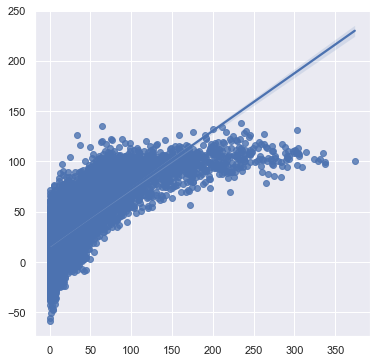

In [274]:
sns.regplot(y_test, lineReg.predict(X_test))

**Let's try applying a polynomial transformation to X.**

In [277]:
from sklearn.preprocessing import PolynomialFeatures

# polynomial transformation (with degree 3)

poly = PolynomialFeatures(degree=2)
poly_X = poly.fit_transform(X)

scores = []
coefs = []
for i in range(1):
    poly_X_train, poly_X_test, y_train, y_test = train_test_split(poly_X, Y, test_size = 0.3, shuffle= True, random_state = 4)
    lineReg = LinearRegression()
    lineReg.fit(poly_X_train, y_train)
    scores.append(lineReg.score(poly_X_test, y_test))
    coefs.append(lineReg.coef_)

print('\nPolymial Transformation + Linear Regression score:', np.mean(scores))
y_pred = lineReg.predict(poly_X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Polymial Transformation + Linear Regression: 0.8001068259671344
Mean Absolute Error: 13.116596688775768
Mean Squared Error: 417.12276607927186
Root Mean Squared Error: 20.423583575838787


This is looking better now. Lets see our plot and coefficients.

**Coefficients of our polynomial features:**

,1,is_weekend,temp_average,precipitation,month,member_casual_member,hour_of_day_01,hour_of_day_02,hour_of_day_03,hour_of_day_04,...,hour_of_day_22^2,hour_of_day_22 hour_of_day_23,hour_of_day_22 rideable_type_docked_bike,hour_of_day_22 rideable_type_electric_bike,hour_of_day_23^2,hour_of_day_23 rideable_type_docked_bike,hour_of_day_23 rideable_type_electric_bike,rideable_type_docked_bike^2,rideable_type_docked_bike rideable_type_electric_bike,rideable_type_electric_bike^2
0,1.0,0.0,11.388889,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,11.388889,0.0,4.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,11.388889,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,11.388889,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,11.388889,0.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


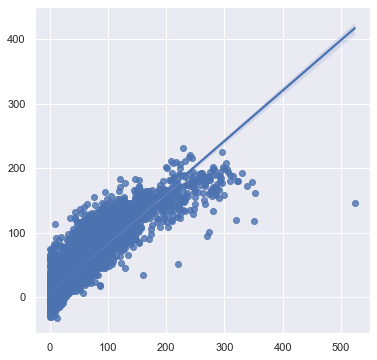

In [278]:
sns.regplot(y_test, lineReg.predict(poly_X_test))

data = daily_totals.drop(columns=['count'])
cols = data.columns.values
features = pd.DataFrame(poly.transform(data), columns=poly.get_feature_names(cols))
features.head()

## Conclusion

Of the factors examined, timing (time of day, weekday/weekend) and public transportation are the biggest factors affecting bike sharing in San Francisco. 

The findings that temperatures from the 10-25 range with no precipitation yields a positive correlation with bike share demand are in line with Eren and Uz's (2020) findings. It also confirms the hypothesis that San Francisco's change in temperature and precipitation over each year is mild enough that seasonality (time of year) does not play a role in bike sharing demand. 

These findings also support the hypothesis and Eren and Uz's (2020) findings that bike shares can act as both a complement to public transportation to reduce travel time and a substitute in areas with poor public transport options.

However, these findings do not support the hypothesis about the negative correlation between bike share usage and crime rates. Crime rate seems to have no effect on bike sharing usage in San Francisco. 


## Limitations

##### COVID-19
Bike share usage has been affected by the Caifornia's stay-at-home orders and changes to movement patterns as people started working from home from March, 2020. 

##### Lyft's eBike Battery Issues
Lyft's battery issues caused Lyft to temporarily suspend their offering of electric bikes from July to mid-December of 2019. As electric bikes are their most popular offering, this caused a drop in usage during the period which these eBikes we not avaialble. When they were put back in January 2020, usage seemed to skyrocket until California announced its statewide stay-at-home order. 

##### Demographics
Many studies examined income and demographics (e.g. age, gender) as significant factors that affect bike share usage. Lyft's anonymized data contains no information on demographics.

## Areas for further research

##### Usage Patterns
It would be helpful to further examine usage patterns (duration, distance, start/end locations) to see *how* people are using bike shares (e.g. Where do those who use bike sharing as a means to get home from a BART station live? Are there any other public transportation options avialable for them?). Is it for convenience, cost, health, leisure or other factors?

##### Electric versus Regular Bikes
The usage of electric bikes are much higher in San Francisco, possibly due to the fact that the city has quite a lot of steeper hills. I would examine the usage patterns of electric versus regular bikes with the user's path to see whether elevation gain is a factor in choosing an electric bike. I would also like to examine whether there is a higher usage of electric bikes when bike sharing is used as a means to get around rather than for leisure (e.g. riding through an area with high crime rates, weekdays, rush hours, late night, riding from a transit stop). 